In [2]:
# Importing Libraries
from tensorflow import keras
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import optimizers, losses
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import image

import pickle
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

In [5]:
# Base Path for all files
data_dir = 'C:/Users/lokes/Downloads/Documents/dataset1/augment'

In [6]:
###### Using ImageDataGenerator to load the Images for Training and Testing the CNN Model
datagenerator = {
    "train": ImageDataGenerator(horizontal_flip=True,
                                vertical_flip=True,
                                rescale=1. / 255,
                                validation_split=0.1,
                                shear_range=0.1,
                                zoom_range=0.1,
                                width_shift_range=0.1,
                                height_shift_range=0.1,
                                rotation_range=30,
                               ).flow_from_directory(directory=data_dir,
                                                     target_size=(256, 256),
                                                     subset='training',
                                                    ),

    "valid": ImageDataGenerator(rescale=1 / 255,
                                validation_split=0.1,
                               ).flow_from_directory(directory=data_dir,
                                                     target_size=(256, 256),
                                                     subset='validation',
                                                    ),
}

Found 5442 images belonging to 3 classes.
Found 603 images belonging to 3 classes.


In [7]:
# Initializing InceptionV3 (pretrained) model with input image shape as (300, 300, 3)
base_model = MobileNetV2(weights=None, include_top=False, input_shape=(256, 256, 3))

# Load Weights for the InceptionV3 Model
base_model.load_weights('C:/Users/lokes/Downloads/Documents/dataset1/mobilenet_v2_weights_tf_dim_ordering_tf_kernels_1.0_192_no_top.h5')

# Setting the Training of all layers of InceptionV3 model to false
base_model.trainable = False

In [8]:
# Adding some more layers at the end of the Model as per our requirement
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.15),
    Dense(1024, activation='relu'),
    Dense(3, activation='softmax') # 10 Output Neurons for 10 Classes
])

In [9]:
# Using the Adam Optimizer to set the learning rate of our final model
opt = optimizers.Adam(learning_rate=0.0001)

# Compiling and setting the parameters we want our model to use
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=['accuracy'])

In [10]:
# Viewing the summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_256 (Funct  (None, 8, 8, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1024)              1311744   
                                                                 
 dense_1 (Dense)             (None, 3)                 3075      
                                                                 
Total params: 3,572,803
Trainable params: 1,314,819
Non-

In [12]:
# Setting variables for the model
batch_size = 32
epochs = 10

# Seperating Training and Testing Data
train_generator = datagenerator["train"]
valid_generator = datagenerator["valid"]

In [13]:
# Calculating variables for the model
steps_per_epoch = train_generator.n // batch_size
validation_steps = valid_generator.n // batch_size

print("steps_per_epoch :", steps_per_epoch)
print("validation_steps :", validation_steps)

steps_per_epoch : 170
validation_steps : 18


In [14]:
# File Path to store the trained models
filepath = "./model_{epoch:02d}-{val_accuracy:.2f}.h5"

# Using the ModelCheckpoint function to train and store all the best models
checkpoint1 = ModelCheckpoint(filepath, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')

callbacks_list = [checkpoint1]
# Training the Model
history = model.fit_generator(generator=train_generator, epochs=epochs, steps_per_epoch=steps_per_epoch,
                              validation_data=valid_generator, validation_steps=validation_steps,
                              callbacks=callbacks_list)

Epoch 1/10
170/170 [==============================] - ETA: 0s - loss: 0.6431 - accuracy: 0.7081
Epoch 1: val_accuracy improved from -inf to 0.76215, saving model to .\model_01-0.76.h5
170/170 [==============================] - 630s 4s/step - loss: 0.6431 - accuracy: 0.7081 - val_loss: 0.5323 - val_accuracy: 0.7622
Epoch 2/10
170/170 [==============================] - ETA: 0s - loss: 0.4430 - accuracy: 0.8198
Epoch 2: val_accuracy did not improve from 0.76215
170/170 [==============================] - 390s 2s/step - loss: 0.4430 - accuracy: 0.8198 - val_loss: 0.5201 - val_accuracy: 0.7587
Epoch 3/10
170/170 [==============================] - ETA: 0s - loss: 0.3703 - accuracy: 0.8508
Epoch 3: val_accuracy did not improve from 0.76215
170/170 [==============================] - 372s 2s/step - loss: 0.3703 - accuracy: 0.8508 - val_loss: 0.5438 - val_accuracy: 0.7413
Epoch 4/10
170/170 [==============================] - ETA: 0s - loss: 0.3279 - accuracy: 0.8686
Epoch 4: val_accuracy did not 

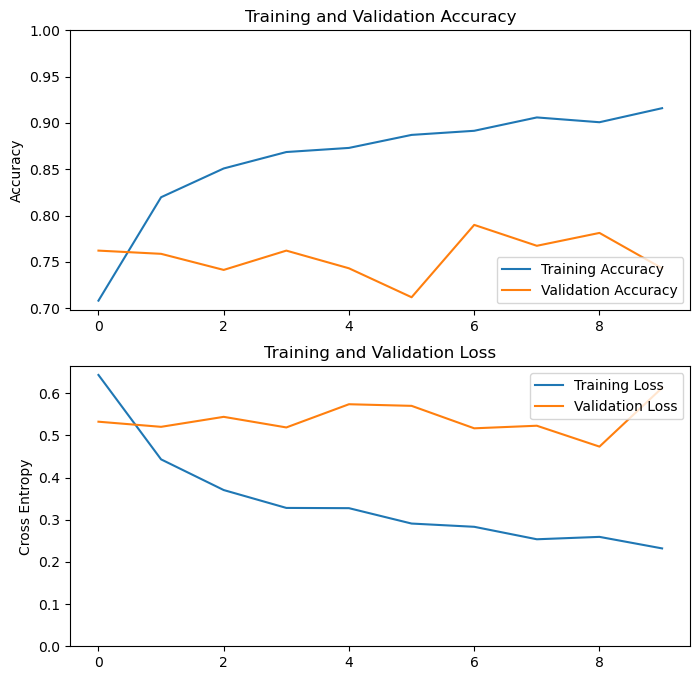

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

# ________________ Graph 1 -------------------------

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

# ________________ Graph 2 -------------------------

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,max(plt.ylim())])
plt.title('Training and Validation Loss')
plt.show()

In [16]:
# Calculate the Loss and Accuracy on the Validation Data
test_loss, test_acc = model.evaluate(valid_generator)
print('test accuracy : ', test_acc)

19/19 [==============================] - 29s 1s/step - loss: 0.6074 - accuracy: 0.7479
test accuracy :  0.7479270100593567


In [23]:
# Check our folder and import the model with best validation accuracy
loaded_best_model = keras.models.load_model("C:/Users/lokes/Downloads/Documents/models/mobilenetv2/model_08-0.79.h5")

# Custom function to load and predict label for the image
def predict(img_rel_path):
    # Import Image from the path with size of (300, 300)
    img = image.load_img(img_rel_path, target_size=(256, 256))

    # Convert Image to a numpy array
    img = image.img_to_array(img, dtype=np.uint8)

    # Scaling the Image Array values between 0 and 1
    img = np.array(img)/255.0

    # Plotting the Loaded Image
    plt.title("Loaded Image")
    plt.axis('off')
    plt.imshow(img.squeeze())
    plt.show()

    # Get the Predicted Label for the loaded Image
    p = loaded_best_model.predict(img[np.newaxis])

    # Label array
    labels = {0: 'Mild', 1: 'Normal', 2:'Severe'}

    print("\n\nMaximum Probability: ", np.max(p[0], axis=-1))
    predicted_class = np.argmax(p[0], axis=-1)
    print("Classified:", predicted_class, "\n")
    if predicted_class == 0:
        print("Mild")
    elif predicted_class == 1:
        print("Normal")
    else:
        print("Severe")
    classes=[]
    prob=[]
    print("\n-------------------Individual Probability--------------------------------\n")

    for i,j in enumerate (p[0],0):
        print(labels[i].upper(),':',round(j*100,2),'%')
        classes.append(labels[i])
        prob.append(round(j*100,2))
        
    return predicted_class

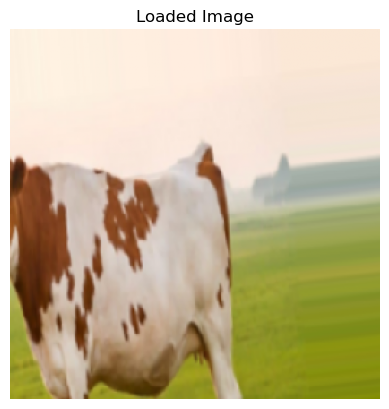

1/1 [==============================] - 0s 97ms/step


Maximum Probability:  0.9979012
Classified: 1 

Normal

-------------------Individual Probability--------------------------------

MILD : 0.12 %
NORMAL : 99.79 %
SEVERE : 0.09 %


1

In [26]:
predict(r'C:\Users\lokes\Documents\Desktop\New folder\_0_55.png')

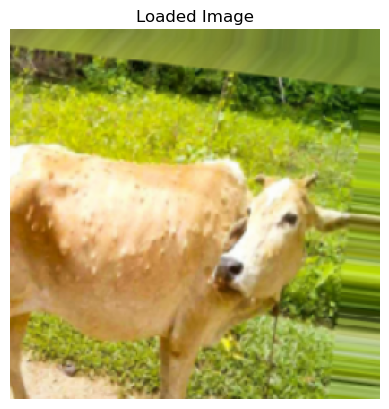

1/1 [==============================] - 0s 146ms/step


Maximum Probability:  0.96709836
Classified: 0 

Mild

-------------------Individual Probability--------------------------------

MILD : 96.71 %
NORMAL : 1.95 %
SEVERE : 1.34 %


0

In [25]:
predict(r'C:\Users\lokes\Documents\Desktop\New folder\_0_957.png')

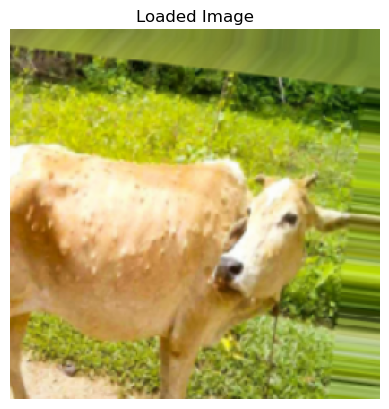

1/1 [==============================] - 0s 110ms/step


Maximum Probability:  0.96709836
Classified: 0 

Mild

-------------------Individual Probability--------------------------------

MILD : 96.71 %
NORMAL : 1.95 %
SEVERE : 1.34 %


0

In [34]:
predict(r'C:\Users\lokes\Documents\Desktop\New folder\_0_957.png')

In [ ]:
import os
from tqdm import tqdm

In [4]:
true_classes = []
predicted_classes = []
test_dir = r"C:\Users\lokes\Downloads\Documents\models\test"
class_names = ['mild', 'normal', 'severe']

for class_name in tqdm(class_names):
    class_dir = os.path.join(test_dir, class_name)
    for img_file in os.listdir(class_dir):
        img_path = os.path.join(class_dir, img_file)
        predicted_class = predict(img_path)
        true_classes.append(class_names.index(class_name))
        predicted_classes.append(predicted_class)


true_classes = np.array(true_classes)
predicted_classes = np.array(predicted_classes)

  0%|                                                                                            | 0/3 [00:00<?, ?it/s]

1/1 [==============================] - 0s 77ms/step


 33%|████████████████████████████                                                        | 1/3 [00:34<01:09, 34.95s/it]

1/1 [==============================] - 0s 64ms/step


 67%|████████████████████████████████████████████████████████                            | 2/3 [01:11<00:35, 35.74s/it]

1/1 [==============================] - 0s 79ms/step


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:48<00:00, 36.25s/it]


In [5]:
true_classes

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [6]:
predicted_classes

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 2, 0, 0, 0, 0,
       0, 0, 0, 0, 2, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       2, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

In [7]:
from sklearn.metrics import accuracy_score, confusion_matrix

In [8]:
accuracy_score(true_classes,predicted_classes)

0.9182098765432098

In [9]:
confusion_matrix(true_classes,predicted_classes)

array([[172,   6,  12],
       [ 11, 217,   2],
       [ 17,   5, 206]], dtype=int64)

In [10]:
from sklearn.metrics import f1_score, precision_score, recall_score

In [11]:
f1_score(true_classes,predicted_classes,average = None)

array([0.88205128, 0.94759825, 0.91964286])

In [12]:
precision_score(true_classes,predicted_classes,average = None)

array([0.86      , 0.95175439, 0.93636364])

In [13]:
recall_score(true_classes,predicted_classes,average = None)

array([0.90526316, 0.94347826, 0.90350877])

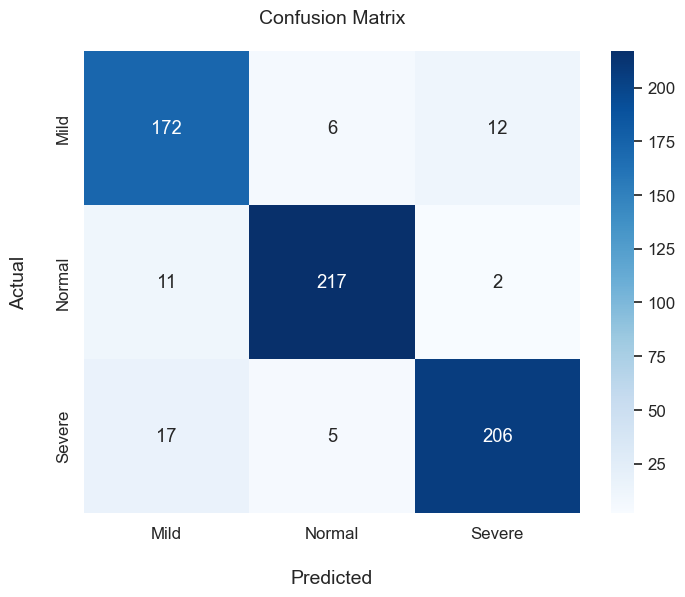

In [14]:
import seaborn as sns

plt.figure(figsize=(8,6), dpi=100)
sns.set(font_scale = 1.1)

cf_matrix = confusion_matrix(true_classes,predicted_classes)

ax = sns.heatmap(cf_matrix, annot=True, fmt='d', cmap = 'Blues')

ax.set_xlabel("Predicted", fontsize=14, labelpad=20)
ax.xaxis.set_ticklabels(['Mild', 'Normal','Severe'])

ax.set_ylabel("Actual", fontsize=14, labelpad=20)
ax.yaxis.set_ticklabels(['Mild', 'Normal','Severe'])

ax.set_title("Confusion Matrix", fontsize=14, pad=20)

plt.show()

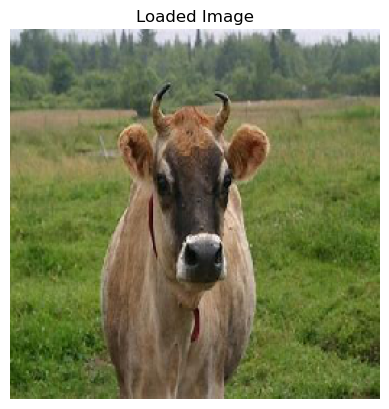

1/1 [==============================] - 0s 73ms/step


Maximum Probability:  0.9834214
Classified: Normal 



-------------------Individual Probability--------------------------------

MILD : 1.0 %
NORMAL : 98.34 %
SEVERE : 0.66 %


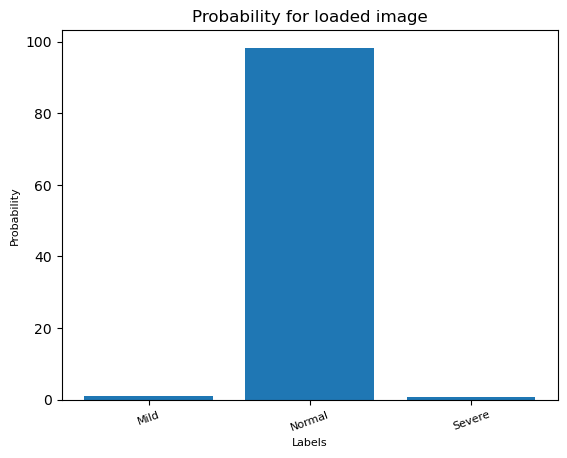

In [27]:
predict("C:/Users/lokes/Downloads/Documents/dataset1/1.jpg")

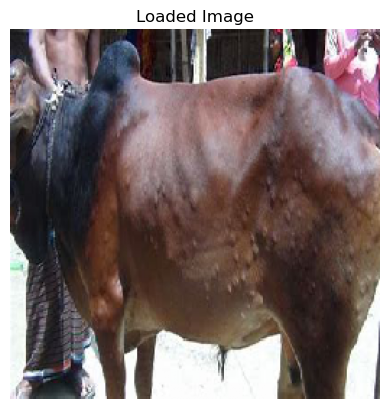

1/1 [==============================] - 0s 56ms/step


Maximum Probability:  0.9046456
Classified: Mild 



-------------------Individual Probability--------------------------------

MILD : 90.46 %
NORMAL : 9.42 %
SEVERE : 0.11 %


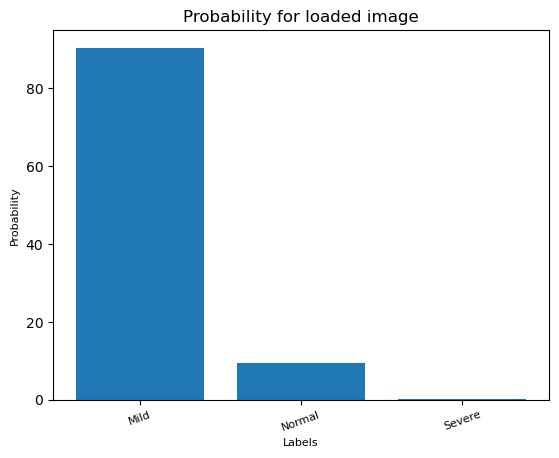

In [28]:
predict("C:/Users/lokes/Downloads/Documents/dataset1/2.jpg")

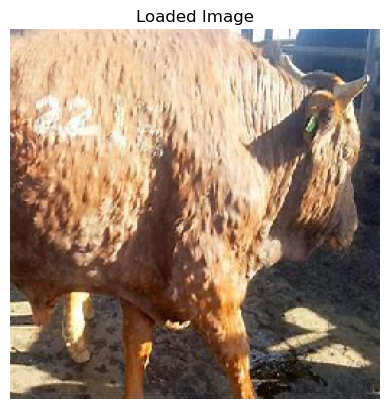

1/1 [==============================] - 0s 57ms/step


Maximum Probability:  0.9746723
Classified: Severe 



-------------------Individual Probability--------------------------------

MILD : 2.5 %
NORMAL : 0.04 %
SEVERE : 97.47 %


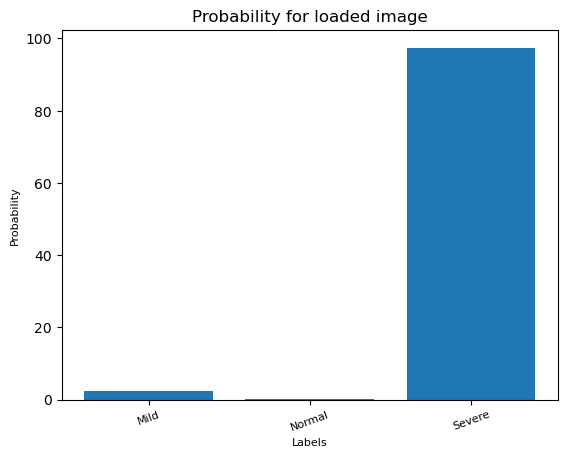

In [29]:
predict("C:/Users/lokes/Downloads/Documents/dataset1/3.jpg")